<a href="https://colab.research.google.com/github/Mohammed-Hatem/mnist-linear-and-deep/blob/main/ML_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning — Assignment 2

##  Team Members
- **Mohammed Hatem**
- **Ahmed Ayman**
- **Joseph Yousery**

# Part A: Linear Classification Models

## A1. Data Preparation

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns

torch.manual_seed(42)

# Load and normalize MNIST data
transform = transforms.ToTensor()
full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset_full = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Combine all images and labels
all_images = torch.cat([img for img, _ in full_train_dataset] + [img for img, _ in test_dataset_full])
all_labels = torch.cat([torch.tensor([label]) for _, label in full_train_dataset] +
                       [torch.tensor([label]) for _, label in test_dataset_full])

# Flatten images to 784 features
X_flat = all_images.contiguous().view(-1, 28 * 28)

# Split data into train/val/test (60/20/20)
X_train, X_temp, Y_train, Y_temp = train_test_split(
    X_flat.numpy(), all_labels.numpy(), test_size=0.4, random_state=42, stratify=all_labels.numpy()
)
X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp
)

# Convert to tensors
X_train, Y_train = torch.from_numpy(X_train).float(), torch.from_numpy(Y_train).long()
X_val, Y_val = torch.from_numpy(X_val).float(), torch.from_numpy(Y_val).long()
X_test, Y_test = torch.from_numpy(X_test).float(), torch.from_numpy(Y_test).long()

# Create DataLoaders
BATCH_SIZE = 64
train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, Y_val), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, Y_test), batch_size=BATCH_SIZE, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 505kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.60MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.22MB/s]


### Helper Functions
These utility functions calculate accuracy, plot metrics, and visualize confusion matrices.

In [ ]:

def calculate_accuracy(model, data_loader, binary_task=False, target_classes=None):
    total_correct, total_samples = 0, 0
    model.eval()
    with torch.no_grad():
        for inputs, targets in data_loader:
            if binary_task:
                mask = (targets == target_classes[0]) | (targets == target_classes[1])
                inputs, targets = inputs[mask], targets[mask]
                targets_binary = (targets == target_classes[1]).float()
                outputs = model(inputs.view(-1, 784))
                preds = (outputs.squeeze() >= 0.5).float()
                total_correct += (preds == targets_binary).sum().item()
                total_samples += targets.size(0)
            else:
                outputs = model(inputs.view(-1, 784))
                _, preds = torch.max(outputs, 1)
                total_correct += (preds == targets).sum().item()
                total_samples += targets.size(0)
    return (total_correct / total_samples) * 100 if total_samples > 0 else 0

def plot_metrics(train_metrics, val_metrics, metric_name):
    plt.figure(figsize=(10, 5))
    plt.plot(train_metrics, label=f'Train {metric_name}')
    plt.plot(val_metrics, label=f'Val {metric_name}')
    plt.title(f'{metric_name} Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.show()

def get_confusion_matrix(model, X_data, Y_data, binary_task=False, target_classes=None):
    model.eval()
    with torch.no_grad():
        if binary_task:
            mask = (Y_data == target_classes[0]) | (Y_data == target_classes[1])
            X_data, Y_data = X_data[mask], Y_data[mask]
            Y_data = (Y_data == target_classes[1]).long()
            outputs = model(X_data.view(-1, 784))
            preds = (outputs.squeeze() >= 0.5).long()
            class_names = [str(c) for c in target_classes]
        else:
            outputs = model(X_data.view(-1, 784))
            _, preds = torch.max(outputs, 1)
            class_names = [str(i) for i in range(10)]
    cm = confusion_matrix(Y_data.cpu().numpy(), preds.cpu().numpy())
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    return cm


## A2. Logistic Regression Implementation

Epoch 10/50: TrainLoss=0.0086, ValLoss=0.0077, ValAcc=99.86%
Epoch 20/50: TrainLoss=0.0058, ValLoss=0.0058, ValAcc=99.86%
Epoch 30/50: TrainLoss=0.0048, ValLoss=0.0049, ValAcc=99.86%
Epoch 40/50: TrainLoss=0.0045, ValLoss=0.0044, ValAcc=99.86%
Epoch 50/50: TrainLoss=0.0038, ValLoss=0.0041, ValAcc=99.86%

--- A2. Binary Logistic Regression (0 vs 1) ---


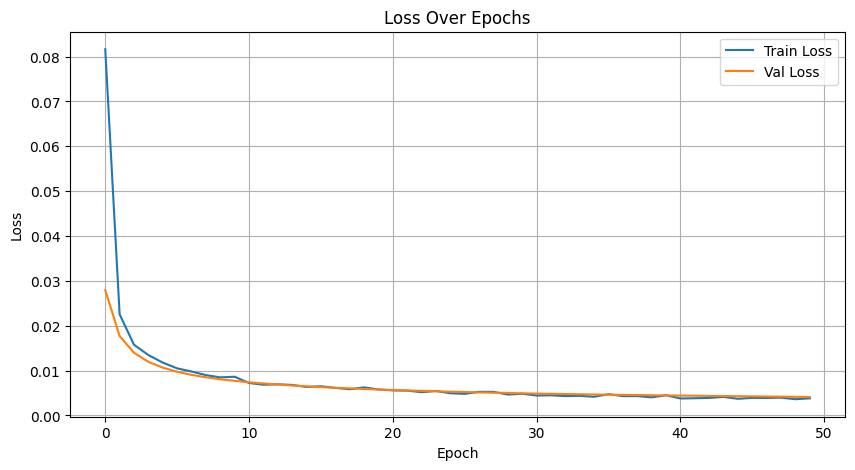

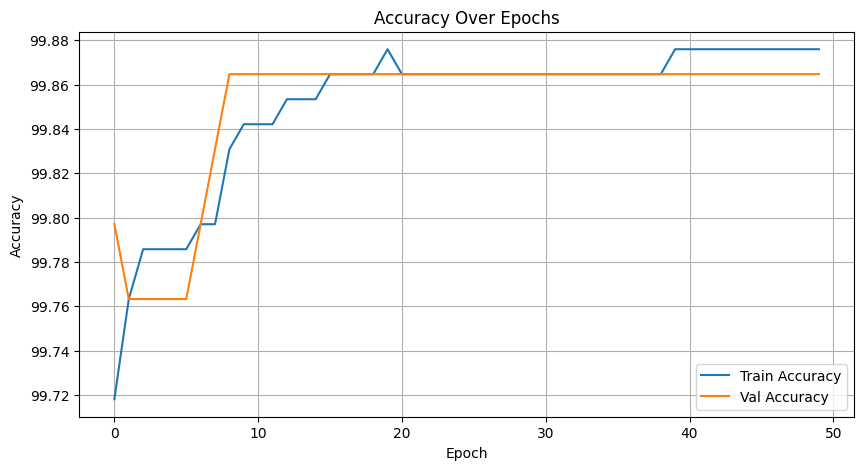

Final Test Accuracy (0 vs 1): 99.86%


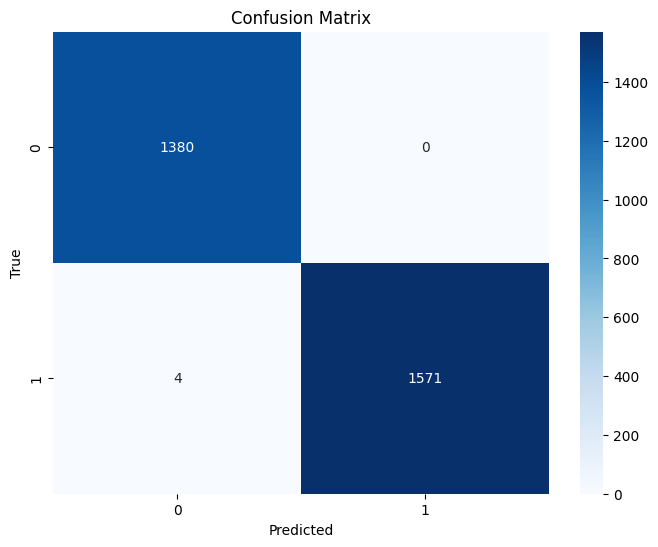

array([[1380,    0],
       [   4, 1571]])

In [ ]:

class LogisticRegressionFromScratch(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegressionFromScratch, self).__init__()
        self.W = nn.Parameter(torch.randn(input_size, 1) * 0.01)
        self.b = nn.Parameter(torch.zeros(1))
    def forward(self, x):
        return torch.sigmoid(torch.matmul(x, self.W) + self.b)

def binary_cross_entropy_loss(y_hat, y):
    y = y.float().view(y_hat.shape)
    eps = 1e-7
    return -torch.mean(y * torch.log(y_hat + eps) + (1 - y) * torch.log(1 - y_hat + eps))

def train_logistic_regression(model, train_loader, val_loader, target_classes, lr=0.01, epochs=50, X_val=None, Y_val=None):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    mask_val = (Y_val == target_classes[0]) | (Y_val == target_classes[1])
    X_val_f, Y_val_f = X_val[mask_val], Y_val[mask_val]
    val_bin = (Y_val_f == target_classes[1]).float()
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X, y in train_loader:
            mask = (y == target_classes[0]) | (y == target_classes[1])
            X, y = X[mask], y[mask]
            if X.size(0) == 0:
                continue
            y_bin = (y == target_classes[1]).float()
            out = model(X.view(-1, 784))
            loss = binary_cross_entropy_loss(out, y_bin)
            total_loss += loss.item()
            loss.backward()
            with torch.no_grad():
                model.W -= lr * model.W.grad
                model.b -= lr * model.b.grad
            model.zero_grad()
        train_losses.append(total_loss / len(train_loader))
        with torch.no_grad():
            val_loss = binary_cross_entropy_loss(model(X_val_f.view(-1, 784)), val_bin)
        val_losses.append(val_loss.item())
        train_accs.append(calculate_accuracy(model, train_loader, True, target_classes))
        val_accs.append(calculate_accuracy(model, val_loader, True, target_classes))
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}: TrainLoss={train_losses[-1]:.4f}, ValLoss={val_losses[-1]:.4f}, ValAcc={val_accs[-1]:.2f}%')
    return train_losses, val_losses, train_accs, val_accs

# Execute Logistic Regression
INPUT_SIZE = 784
LR_CLASSES = [0, 1]
lr_model = LogisticRegressionFromScratch(INPUT_SIZE)
lr_train_l, lr_val_l, lr_train_a, lr_val_a = train_logistic_regression(lr_model, train_loader, val_loader, LR_CLASSES, 0.01, 50, X_val, Y_val)
print("\n--- A2. Binary Logistic Regression (0 vs 1) ---")
plot_metrics(lr_train_l, lr_val_l, 'Loss')
plot_metrics(lr_train_a, lr_val_a, 'Accuracy')
lr_test_loader = DataLoader(TensorDataset(X_test, Y_test), batch_size=BATCH_SIZE, shuffle=False)
test_acc_lr = calculate_accuracy(lr_model, lr_test_loader, True, LR_CLASSES)
print(f"Final Test Accuracy (0 vs 1): {test_acc_lr:.2f}%")
mask_test = (Y_test == LR_CLASSES[0]) | (Y_test == LR_CLASSES[1])
get_confusion_matrix(lr_model, X_test[mask_test], Y_test[mask_test], True, LR_CLASSES)


## A3. Softmax Regression Implementation

Epoch 10/50: TrainLoss=0.3721, ValLoss=0.3778, ValAcc=89.75%
Epoch 20/50: TrainLoss=0.3294, ValLoss=0.3404, ValAcc=90.41%
Epoch 30/50: TrainLoss=0.3098, ValLoss=0.3250, ValAcc=90.85%
Epoch 40/50: TrainLoss=0.2988, ValLoss=0.3157, ValAcc=91.04%
Epoch 50/50: TrainLoss=0.2909, ValLoss=0.3098, ValAcc=91.26%

--- A3. Softmax Regression (Multi-class) ---


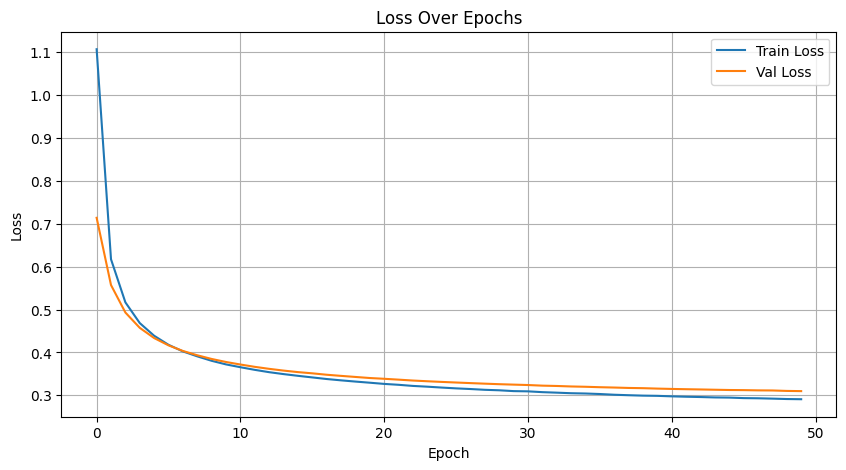

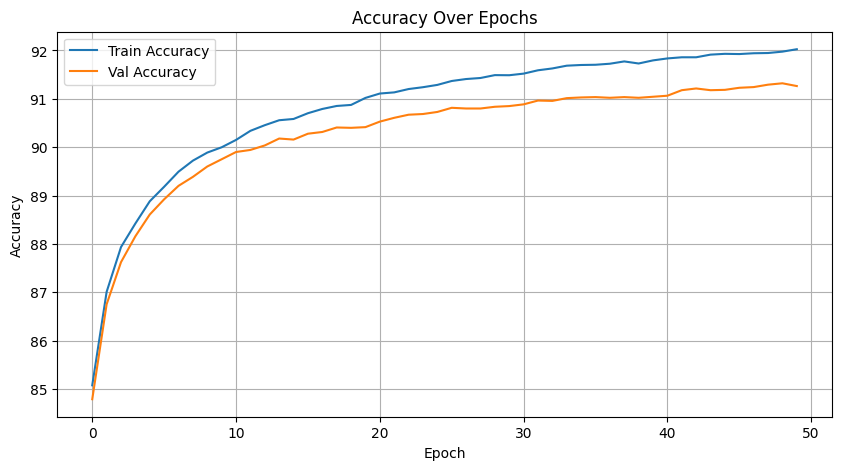

Final Test Accuracy (10 classes): 91.31%


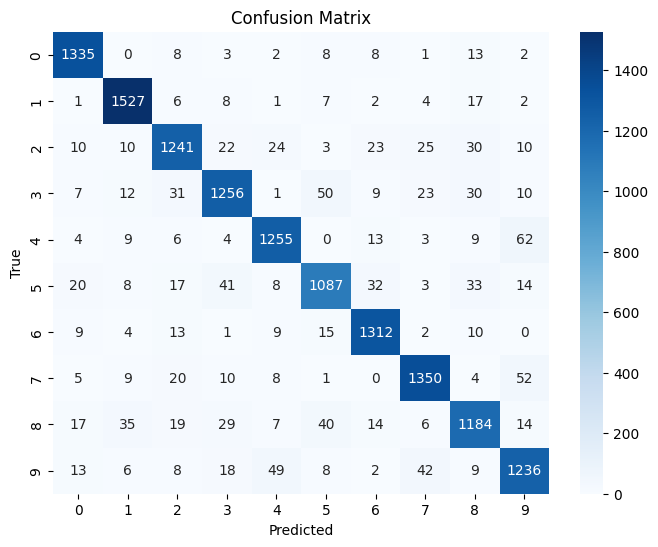

   Class  Accuracy (%)
0      0         96.74
1      1         96.95
2      2         88.77
3      3         87.89
4      4         91.94
5      5         86.06
6      6         95.42
7      7         92.53
8      8         86.74
9      9         88.86


In [ ]:

class SoftmaxRegressionFromScratch(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SoftmaxRegressionFromScratch, self).__init__()
        self.W = nn.Parameter(torch.randn(input_size, num_classes) * 0.01)
        self.b = nn.Parameter(torch.zeros(num_classes))
    def forward(self, x):
        return torch.matmul(x, self.W) + self.b

def train_softmax_regression(model, train_loader, val_loader, lr=0.01, epochs=50):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    X_val_f = X_val.view(-1, 784)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X, y in train_loader:
            X = X.view(-1, 784)
            logits = model(X)
            loss = F.cross_entropy(logits, y.long())
            total_loss += loss.item()
            loss.backward()
            with torch.no_grad():
                model.W -= lr * model.W.grad
                model.b -= lr * model.b.grad
            model.zero_grad()
        train_losses.append(total_loss / len(train_loader))
        with torch.no_grad():
            val_loss = F.cross_entropy(model(X_val_f), Y_val.long())
        val_losses.append(val_loss.item())
        train_accs.append(calculate_accuracy(model, train_loader))
        val_accs.append(calculate_accuracy(model, val_loader))
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}: TrainLoss={train_losses[-1]:.4f}, ValLoss={val_losses[-1]:.4f}, ValAcc={val_accs[-1]:.2f}%')
    return train_losses, val_losses, train_accs, val_accs

# Execute Softmax Regression
sm_model = SoftmaxRegressionFromScratch(INPUT_SIZE, 10)
sm_train_l, sm_val_l, sm_train_a, sm_val_a = train_softmax_regression(sm_model, train_loader, val_loader, 0.01, 50)
print("\n--- A3. Softmax Regression (Multi-class) ---")
plot_metrics(sm_train_l, sm_val_l, 'Loss')
plot_metrics(sm_train_a, sm_val_a, 'Accuracy')
test_acc_sm = calculate_accuracy(sm_model, test_loader)
print(f"Final Test Accuracy (10 classes): {test_acc_sm:.2f}%")
sm_cm = get_confusion_matrix(sm_model, X_test, Y_test)
cm_norm = sm_cm.astype('float') / sm_cm.sum(axis=1)[:, np.newaxis]
per_class_acc = cm_norm.diagonal() * 100
print(pd.DataFrame({'Class': [i for i in range(10)], 'Accuracy (%)': per_class_acc.round(2)}))


#Neural Network

#Data Preperation

In [9]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

tran = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data_full = datasets.MNIST(root='./data', train=True, download=True, transform=tran)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=tran)

#split the train into 75% train 25% validation
train_size = int(0.75 * len(train_data_full))
val_size = len(train_data_full) - train_size
train_data, val_data = random_split(train_data_full, [train_size, val_size])


loaders = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True),
    'val': torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False),
    'test': torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)
}

print(train_data)

print("Train batches:", len(loaders['train']))
print("Validation batches:", len(loaders['val']))
print("Test batches:", len(loaders['test']))


Using device: cuda
Train batches: 704
Validation batches: 235
Test batches: 157


# B1 Model creation

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



class Model(nn.Module):
  def __init__(self, inp_size = (28*28), h1 = 200, h2=50,classes = 10):
    super(Model, self).__init__()
    self.fc1 = nn.Linear(inp_size, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.out = nn.Linear(h2, classes)

    for layer in [self.fc1, self.fc2, self.out]:
      nn.init.xavier_uniform_(layer.weight)
      nn.init.zeros_(layer.bias)

  def forward(self, x):
    x  = x.view(x.size(0), -1) #flatten the images into [64,784]
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.out(x) #logits
    return x


model = Model()
print(model)




Model(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=50, bias=True)
  (out): Linear(in_features=50, out_features=10, bias=True)
)


# B2. Training Infrastructure

In [14]:
import time
import numpy as np
import torch

epochs = 100
lr = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# accuracy helper
def accuracy(preds, labels):
    return (preds.argmax(1) == labels).float().mean()

# lists for visualization
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# for error bars
batch_accs_per_epoch = []
val_batch_accs_per_epoch = []

# early stopping
patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_path = "best_model.pt"

# move model to device
model.to(device)

start_time = time.time()

for epoch in range(epochs):

    #training
    model.train()
    epoch_train_loss, epoch_train_acc = 0.0, 0.0
    batch_accs = []  # store batch accuracies for error bars

    for images, labels in loaders['train']:
        images, labels = images.to(device), labels.to(device)

        # forward
        logits = model(images)
        loss = criterion(logits, labels)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # metrics
        batch_accuracy = accuracy(logits, labels).item()
        batch_accs.append(batch_accuracy)
        epoch_train_loss += loss.item() * images.size(0)
        epoch_train_acc  += batch_accuracy * images.size(0)

    batch_accs_per_epoch.append(batch_accs)

    # validation
    model.eval()
    epoch_val_loss, epoch_val_acc = 0.0, 0.0
    val_batch_accs = []

    with torch.no_grad():
        for images, labels in loaders['val']:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            batch_accuracy = accuracy(logits, labels).item()
            val_batch_accs.append(batch_accuracy)
            epoch_val_loss += loss.item() * images.size(0)
            epoch_val_acc  += batch_accuracy * images.size(0)

    val_batch_accs_per_epoch.append(val_batch_accs)

    # normalize
    train_loss_epoch = epoch_train_loss / len(loaders['train'].dataset)
    val_loss_epoch   = epoch_val_loss   / len(loaders['val'].dataset)
    train_acc_epoch  = epoch_train_acc  / len(loaders['train'].dataset)
    val_acc_epoch    = epoch_val_acc    / len(loaders['val'].dataset)

    train_losses.append(train_loss_epoch)
    val_losses.append(val_loss_epoch)
    train_accs.append(train_acc_epoch)
    val_accs.append(val_acc_epoch)


    print(f"Epoch {epoch+1:03d}/{epochs} | "
          f"Train Loss: {train_loss_epoch:.4f} | Val Loss: {val_loss_epoch:.4f} | "
          f"Train Acc: {train_acc_epoch*100:.2f}% | Val Acc: {val_acc_epoch*100:.2f}%")

    #early stopping
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)  # save best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

end_time = time.time()
elapsed = end_time - start_time
print(f"\nTraining completed in {elapsed/60:.2f} minutes")
print(f"Best validation loss: {best_val_loss:.4f}")

# Load the best model weights (for evaluation later)
model.load_state_dict(torch.load(best_model_path))


Epoch 001/100 | Train Loss: 0.0151 | Val Loss: 0.0961 | Train Acc: 99.76% | Val Acc: 97.28%
Epoch 002/100 | Train Loss: 0.0147 | Val Loss: 0.1167 | Train Acc: 99.78% | Val Acc: 96.72%
Epoch 003/100 | Train Loss: 0.0143 | Val Loss: 0.0970 | Train Acc: 99.80% | Val Acc: 97.21%
Epoch 004/100 | Train Loss: 0.0137 | Val Loss: 0.0947 | Train Acc: 99.83% | Val Acc: 97.37%
Epoch 005/100 | Train Loss: 0.0133 | Val Loss: 0.1077 | Train Acc: 99.81% | Val Acc: 97.02%
Epoch 006/100 | Train Loss: 0.0129 | Val Loss: 0.1035 | Train Acc: 99.84% | Val Acc: 97.03%
Epoch 007/100 | Train Loss: 0.0123 | Val Loss: 0.0970 | Train Acc: 99.85% | Val Acc: 97.26%
Epoch 008/100 | Train Loss: 0.0120 | Val Loss: 0.0961 | Train Acc: 99.87% | Val Acc: 97.19%
Epoch 009/100 | Train Loss: 0.0116 | Val Loss: 0.0976 | Train Acc: 99.86% | Val Acc: 97.35%
Epoch 010/100 | Train Loss: 0.0111 | Val Loss: 0.0973 | Train Acc: 99.88% | Val Acc: 97.39%
Epoch 011/100 | Train Loss: 0.0109 | Val Loss: 0.0953 | Train Acc: 99.87% | Val 

<All keys matched successfully>

#B3 Performance visualization

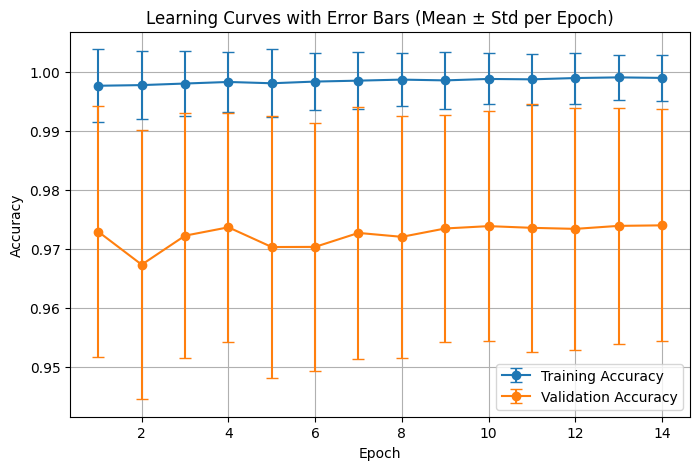

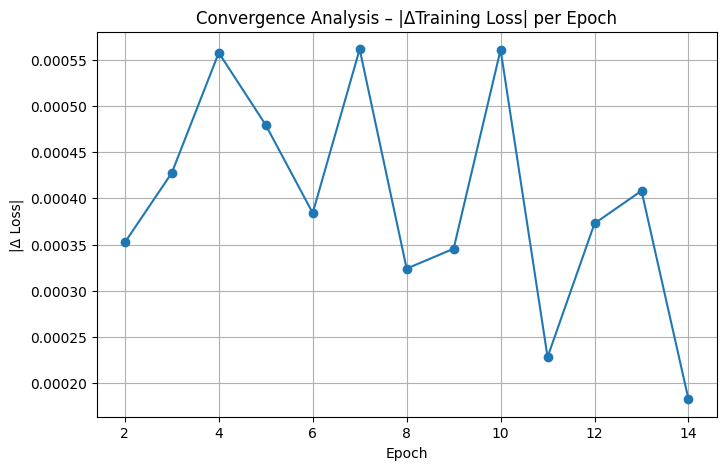

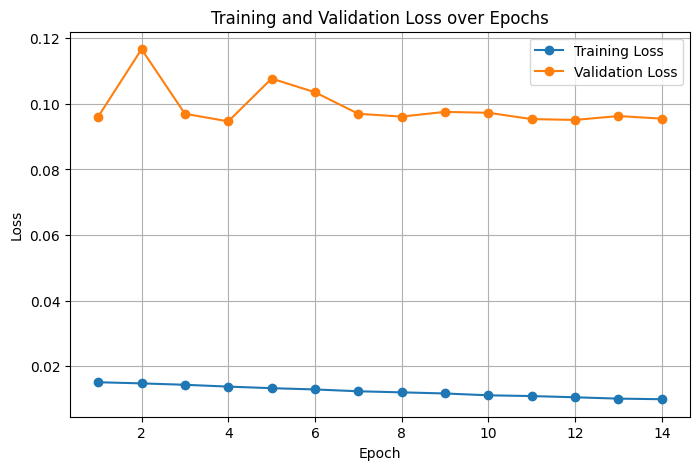

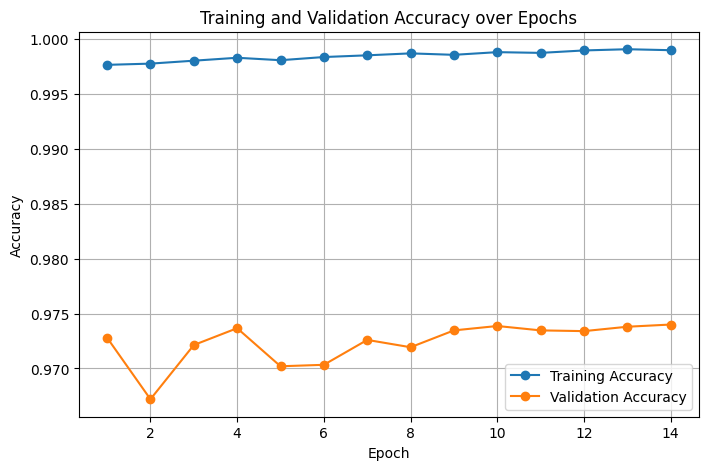

In [17]:

import numpy as np
import matplotlib.pyplot as plt

epochs_range = range(1, len(train_losses) + 1)


if 'batch_accs_per_epoch' in globals() and 'val_batch_accs_per_epoch' in globals():
    train_means = [np.mean(b) for b in batch_accs_per_epoch]
    train_stds  = [np.std(b)  for b in batch_accs_per_epoch]
    val_means   = [np.mean(b) for b in val_batch_accs_per_epoch]
    val_stds    = [np.std(b)  for b in val_batch_accs_per_epoch]

    plt.figure(figsize=(8,5))
    plt.errorbar(epochs_range, train_means, yerr=train_stds, fmt='-o', capsize=4, label="Training Accuracy")
    plt.errorbar(epochs_range, val_means,   yerr=val_stds,   fmt='-o', capsize=4, label="Validation Accuracy")
    plt.title("Learning Curves with Error Bars (Mean ± Std per Epoch)")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.legend(); plt.grid(True)
    plt.show()
else:
    print("⚠️ To display error-bar curves, record mini-batch accuracies during training.")

# Convergence Analysis
loss_diff = np.abs(np.diff(train_losses))
plt.figure(figsize=(8,5))
plt.plot(range(2, len(train_losses)+1), loss_diff, marker='o')
plt.title("Convergence Analysis – |ΔTraining Loss| per Epoch")
plt.xlabel("Epoch"); plt.ylabel("|Δ Loss|")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs_range, train_losses, 'o-', label="Training Loss")
plt.plot(epochs_range, val_losses,   'o-', label="Validation Loss")
plt.title("Training and Validation Loss over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(True)
plt.show()

# Training & Validation Accuracy
plt.figure(figsize=(8,5))
plt.plot(epochs_range, train_accs, 'o-', label="Training Accuracy")
plt.plot(epochs_range, val_accs,   'o-', label="Validation Accuracy")
plt.title("Training and Validation Accuracy over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(True)
plt.show()


# Test evaluation

Test Accuracy: 97.45%


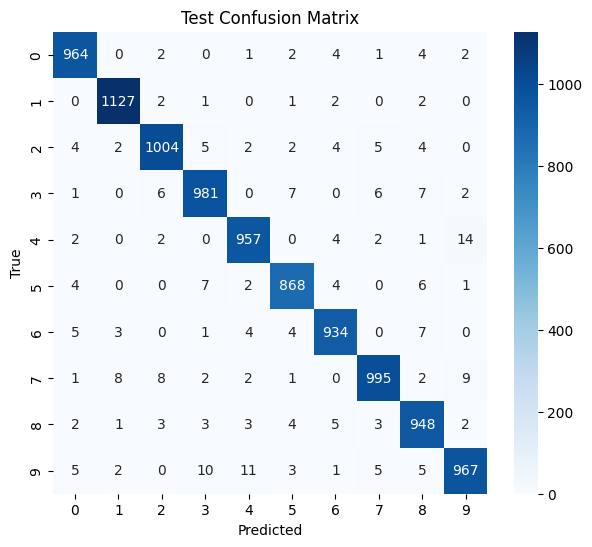

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for x, y in loaders['test']:
        x, y = x.to(device), y.to(device)
        preds = model(x).argmax(1)
        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

acc = (all_preds == all_labels).float().mean().item()
print(f"Test Accuracy: {acc*100:.2f}%")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Test Confusion Matrix")
plt.show()


## Part D: Advanced Techniques (Bonus)

Reshaping flat data loaders to 4D (B, 1, 28, 28) for NN/CNN...

--- D1. CNN vs FNN Performance Comparison ---
Training FNN Baseline...
Epoch 1/10: TrainLoss=1.9849, ValLoss=1.3178, ValAcc=73.60%
Epoch 2/10: TrainLoss=0.8086, ValLoss=0.5620, ValAcc=84.97%
Epoch 3/10: TrainLoss=0.4774, ValLoss=0.4317, ValAcc=88.03%
Epoch 4/10: TrainLoss=0.3949, ValLoss=0.3840, ValAcc=88.88%
Epoch 5/10: TrainLoss=0.3556, ValLoss=0.3630, ValAcc=89.39%
Epoch 6/10: TrainLoss=0.3297, ValLoss=0.3331, ValAcc=90.46%
Epoch 7/10: TrainLoss=0.3095, ValLoss=0.3153, ValAcc=90.85%
Epoch 8/10: TrainLoss=0.2927, ValLoss=0.3035, ValAcc=91.26%
Epoch 9/10: TrainLoss=0.2782, ValLoss=0.2889, ValAcc=91.71%
Epoch 10/10: TrainLoss=0.2650, ValLoss=0.2805, ValAcc=91.84%
Test Accuracy for FNN Baseline: 91.96%
Per-Class Accuracy (%):
[97.61 97.27 89.34 88.03 93.19 87.25 96.22 94.79 87.77 87.06]


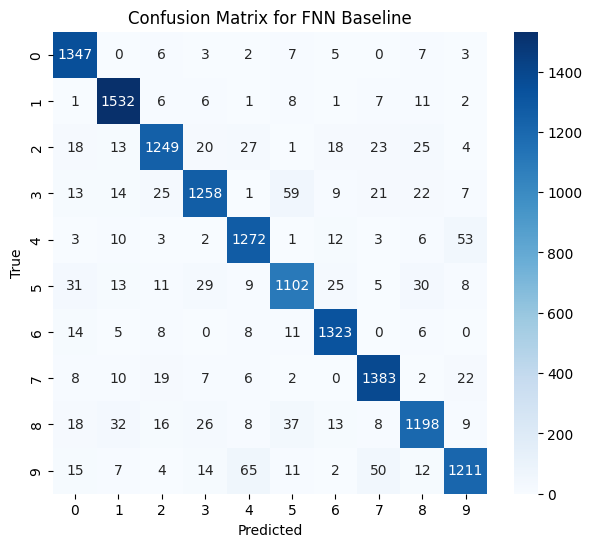


Training CNN Baseline...
Epoch 1/10: TrainLoss=1.4399, ValLoss=0.5514, ValAcc=79.59%
Epoch 2/10: TrainLoss=0.3619, ValLoss=0.6214, ValAcc=78.92%
Epoch 3/10: TrainLoss=0.2660, ValLoss=0.2387, ValAcc=92.59%
Epoch 4/10: TrainLoss=0.2033, ValLoss=0.2010, ValAcc=93.81%
Epoch 5/10: TrainLoss=0.1653, ValLoss=0.1569, ValAcc=95.09%
Epoch 6/10: TrainLoss=0.1387, ValLoss=0.1615, ValAcc=94.84%
Epoch 7/10: TrainLoss=0.1177, ValLoss=0.1289, ValAcc=96.02%
Epoch 8/10: TrainLoss=0.1035, ValLoss=0.1577, ValAcc=94.71%
Epoch 9/10: TrainLoss=0.0923, ValLoss=0.1233, ValAcc=96.03%
Epoch 10/10: TrainLoss=0.0834, ValLoss=0.0929, ValAcc=97.00%
Test Accuracy for CNN Baseline: 97.30%
Per-Class Accuracy (%):
[98.48 98.73 98.78 96.15 96.19 95.8  98.84 98.36 94.51 96.76]


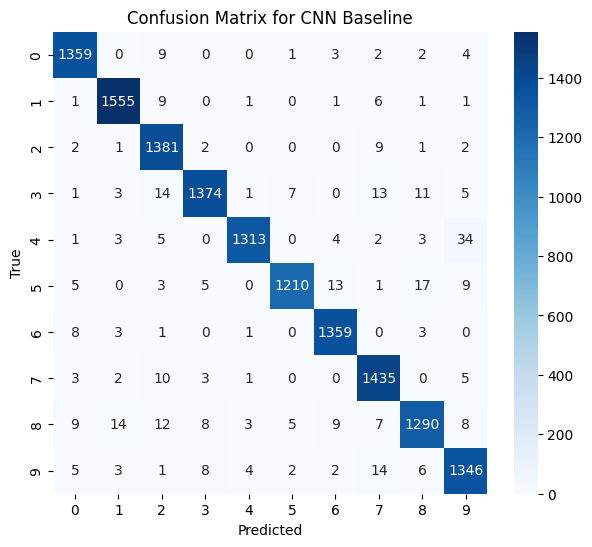


Analysis: CNN Accuracy (97.30%) vs FNN Accuracy (91.96%). The CNN should demonstrate the benefit of spatial feature learning, achieving a higher accuracy by using convolutional filters to extract edges and patterns.

--- D2. Dropout Analysis ---

Training CNN with Dropout 0.1...
Epoch 1/10: TrainLoss=1.4352, ValLoss=0.4807, ValAcc=85.84%
Epoch 2/10: TrainLoss=0.3917, ValLoss=0.3222, ValAcc=90.09%
Epoch 3/10: TrainLoss=0.2844, ValLoss=0.2447, ValAcc=92.24%
Epoch 4/10: TrainLoss=0.2221, ValLoss=0.1889, ValAcc=94.28%
Epoch 5/10: TrainLoss=0.1814, ValLoss=0.2803, ValAcc=90.72%
Epoch 6/10: TrainLoss=0.1526, ValLoss=0.1394, ValAcc=95.69%
Epoch 7/10: TrainLoss=0.1328, ValLoss=0.1328, ValAcc=95.88%
Epoch 8/10: TrainLoss=0.1188, ValLoss=0.1087, ValAcc=96.71%
Epoch 9/10: TrainLoss=0.1062, ValLoss=0.1023, ValAcc=96.93%
Epoch 10/10: TrainLoss=0.0952, ValLoss=0.0931, ValAcc=97.08%
Test Accuracy for CNN Dropout 0.1: 97.34%
Per-Class Accuracy (%):
[99.28 98.35 97.78 97.97 98.1  95.8  98.47 97.12 95.

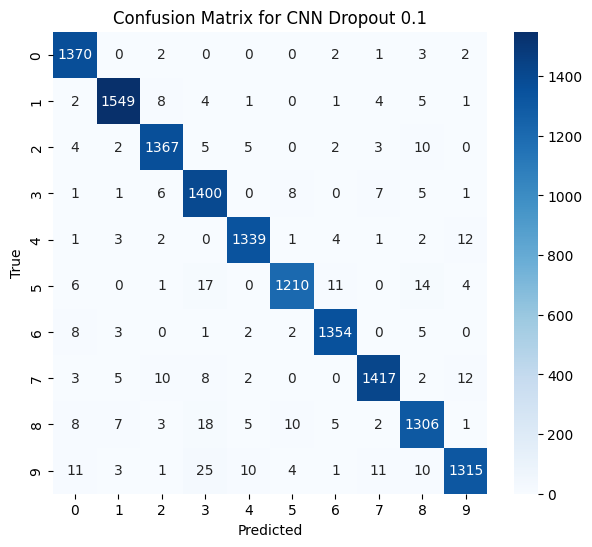


Training CNN with Dropout 0.3...
Epoch 1/10: TrainLoss=1.5469, ValLoss=0.5814, ValAcc=81.09%
Epoch 2/10: TrainLoss=0.4272, ValLoss=0.3256, ValAcc=89.84%
Epoch 3/10: TrainLoss=0.3084, ValLoss=0.2282, ValAcc=93.04%
Epoch 4/10: TrainLoss=0.2437, ValLoss=0.1855, ValAcc=94.20%
Epoch 5/10: TrainLoss=0.2009, ValLoss=0.1545, ValAcc=95.22%
Epoch 6/10: TrainLoss=0.1732, ValLoss=0.1485, ValAcc=95.30%
Epoch 7/10: TrainLoss=0.1526, ValLoss=0.1184, ValAcc=96.22%
Epoch 8/10: TrainLoss=0.1360, ValLoss=0.1058, ValAcc=96.72%
Epoch 9/10: TrainLoss=0.1222, ValLoss=0.0978, ValAcc=96.94%
Epoch 10/10: TrainLoss=0.1130, ValLoss=0.0967, ValAcc=96.98%
Test Accuracy for CNN Dropout 0.3: 97.09%
Per-Class Accuracy (%):
[99.13 98.16 98.86 97.2  97.73 94.54 98.91 95.2  96.34 94.61]


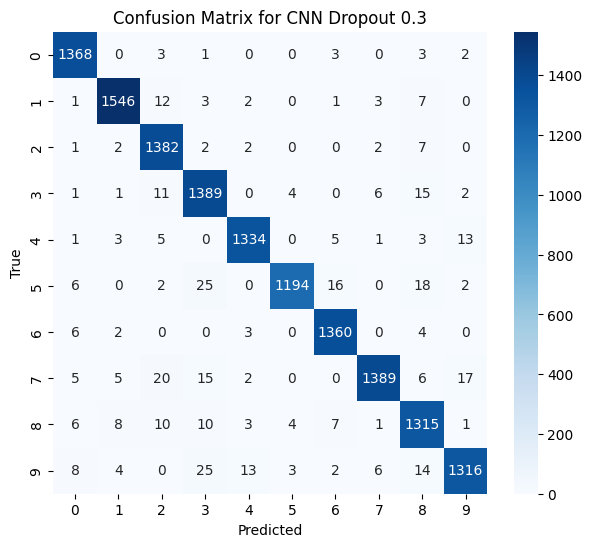


Training CNN with Dropout 0.5...
Epoch 1/10: TrainLoss=1.5717, ValLoss=0.5280, ValAcc=84.81%
Epoch 2/10: TrainLoss=0.5123, ValLoss=0.3231, ValAcc=90.29%
Epoch 3/10: TrainLoss=0.3801, ValLoss=0.2908, ValAcc=91.33%
Epoch 4/10: TrainLoss=0.3063, ValLoss=0.2060, ValAcc=93.85%
Epoch 5/10: TrainLoss=0.2620, ValLoss=0.1915, ValAcc=94.08%
Epoch 6/10: TrainLoss=0.2237, ValLoss=0.1554, ValAcc=95.37%
Epoch 7/10: TrainLoss=0.1981, ValLoss=0.1371, ValAcc=95.70%
Epoch 8/10: TrainLoss=0.1800, ValLoss=0.1202, ValAcc=96.24%
Epoch 9/10: TrainLoss=0.1632, ValLoss=0.1265, ValAcc=95.93%
Epoch 10/10: TrainLoss=0.1515, ValLoss=0.1162, ValAcc=96.45%
Test Accuracy for CNN Dropout 0.5: 96.48%
Per-Class Accuracy (%):
[99.49 98.54 97.14 94.26 97.   94.38 98.69 96.85 90.77 97.2 ]


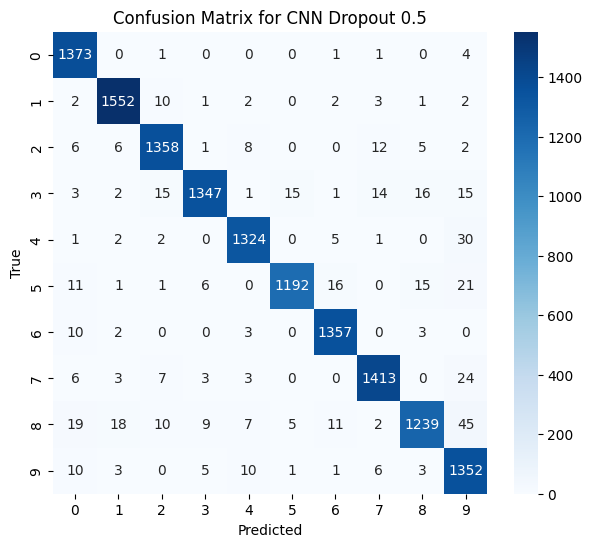


Training CNN with Dropout 0.7...
Epoch 1/10: TrainLoss=1.5439, ValLoss=0.5475, ValAcc=85.08%
Epoch 2/10: TrainLoss=0.6223, ValLoss=0.3243, ValAcc=90.67%
Epoch 3/10: TrainLoss=0.4763, ValLoss=0.2422, ValAcc=93.01%
Epoch 4/10: TrainLoss=0.3828, ValLoss=0.1968, ValAcc=94.19%
Epoch 5/10: TrainLoss=0.3193, ValLoss=0.1692, ValAcc=94.95%
Epoch 6/10: TrainLoss=0.2772, ValLoss=0.1423, ValAcc=95.69%
Epoch 7/10: TrainLoss=0.2382, ValLoss=0.1257, ValAcc=96.18%
Epoch 8/10: TrainLoss=0.2130, ValLoss=0.1109, ValAcc=96.69%
Epoch 9/10: TrainLoss=0.1948, ValLoss=0.1010, ValAcc=96.89%
Epoch 10/10: TrainLoss=0.1816, ValLoss=0.0940, ValAcc=97.09%
Test Accuracy for CNN Dropout 0.7: 97.23%
Per-Class Accuracy (%):
[98.99 98.54 97.78 96.78 98.17 96.83 98.62 96.23 94.95 95.26]


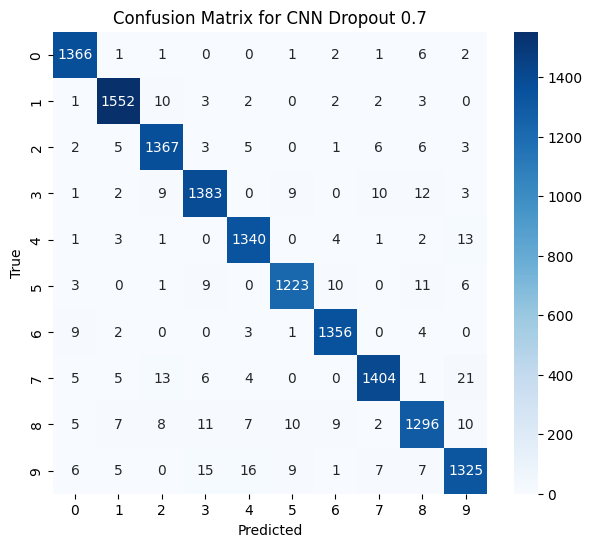


--- D2. Batch Normalization and Combined Effect ---
Training CNN with BatchNorm ONLY...
Epoch 1/10: TrainLoss=0.3025, ValLoss=0.1283, ValAcc=96.21%
Epoch 2/10: TrainLoss=0.0916, ValLoss=0.1030, ValAcc=96.89%
Epoch 3/10: TrainLoss=0.0668, ValLoss=0.0677, ValAcc=97.90%
Epoch 4/10: TrainLoss=0.0545, ValLoss=0.0587, ValAcc=98.29%
Epoch 5/10: TrainLoss=0.0463, ValLoss=0.0589, ValAcc=98.12%
Epoch 6/10: TrainLoss=0.0402, ValLoss=0.0705, ValAcc=97.75%
Epoch 7/10: TrainLoss=0.0358, ValLoss=0.0908, ValAcc=97.03%
Epoch 8/10: TrainLoss=0.0325, ValLoss=0.0505, ValAcc=98.41%
Epoch 9/10: TrainLoss=0.0283, ValLoss=0.0444, ValAcc=98.57%
Epoch 10/10: TrainLoss=0.0257, ValLoss=0.0426, ValAcc=98.61%
Test Accuracy for CNN BatchNorm: 98.79%
Per-Class Accuracy (%):
[99.49 99.37 97.93 99.23 98.9  98.5  98.98 98.97 98.39 97.99]


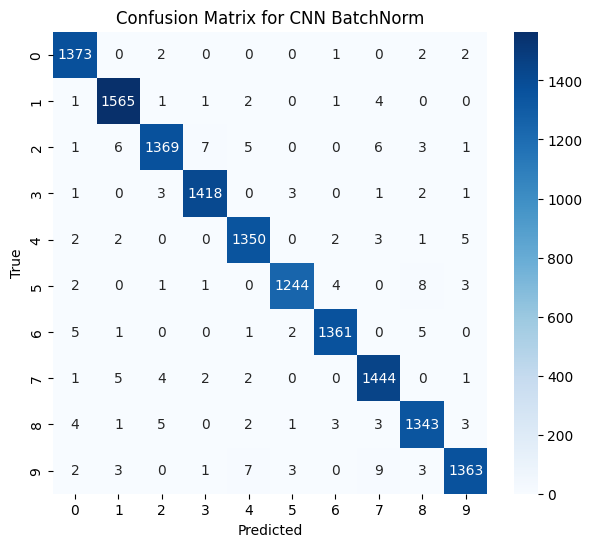


Training CNN with BatchNorm + Dropout 0.5 (Combined Effect)...
Epoch 1/10: TrainLoss=0.4232, ValLoss=0.1268, ValAcc=96.34%
Epoch 2/10: TrainLoss=0.1456, ValLoss=0.0975, ValAcc=97.21%
Epoch 3/10: TrainLoss=0.1049, ValLoss=0.0652, ValAcc=98.14%
Epoch 4/10: TrainLoss=0.0866, ValLoss=0.0679, ValAcc=97.96%
Epoch 5/10: TrainLoss=0.0745, ValLoss=0.0517, ValAcc=98.48%
Epoch 6/10: TrainLoss=0.0648, ValLoss=0.0529, ValAcc=98.38%
Epoch 7/10: TrainLoss=0.0606, ValLoss=0.0461, ValAcc=98.54%
Epoch 8/10: TrainLoss=0.0546, ValLoss=0.0437, ValAcc=98.59%
Epoch 9/10: TrainLoss=0.0506, ValLoss=0.0477, ValAcc=98.51%
Epoch 10/10: TrainLoss=0.0461, ValLoss=0.0400, ValAcc=98.62%
Test Accuracy for CNN BN + Dropout 0.5: 98.83%
Per-Class Accuracy (%):
[99.49 98.86 99.   99.02 98.68 98.57 98.98 98.97 98.53 98.13]


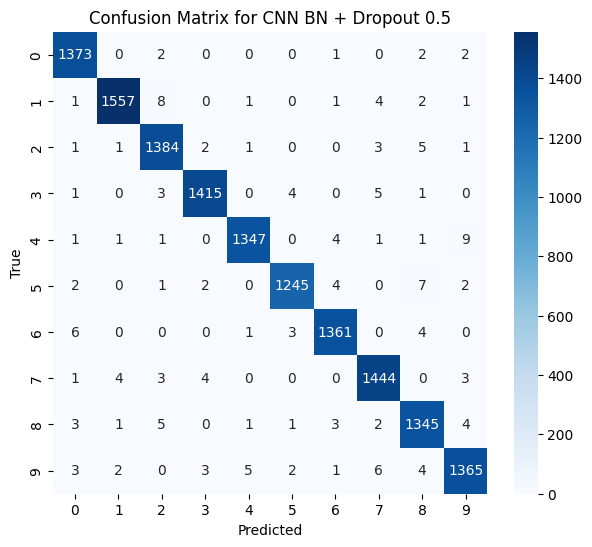


--- Final Summary of Bonus Results ---
FNN Baseline Accuracy: 91.96%
CNN Baseline Accuracy: 97.30%
--- Dropout Analysis ---
Dropout 0.1 Accuracy: 97.34%
Dropout 0.3 Accuracy: 97.09%
Dropout 0.5 Accuracy: 96.48%
Dropout 0.7 Accuracy: 97.23%
--- Batch Norm Analysis ---
BatchNorm ONLY Accuracy: 98.79%
BN + Dropout 0.5 Accuracy (Combined Effect): 98.83%


In [ ]:
import time, copy, torch, torch.nn as nn, torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from torch.utils.data import TensorDataset, DataLoader

#Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 10
LR = 0.01

# FNN Architecture for Comparison (Matches Part B minimum)
class SimpleFNN(nn.Module):
    def __init__(self, dropout_rate=0.0, use_batchnorm=False):
        super(SimpleFNN, self).__init__()
        self.use_batchnorm = use_batchnorm
        self.fc1 = nn.Linear(784, 128)
        self.bn1 = nn.BatchNorm1d(128) if use_batchnorm else nn.Identity()
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64) if use_batchnorm else nn.Identity()
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity()

    def forward(self, x):
        # Flatten input from (B, 1, 28, 28) to (B, 784)
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# CNN Architecture
class SimpleCNN(nn.Module):
    def __init__(self, dropout_rate=0.0, use_batchnorm=False):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) if use_batchnorm else None
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64) if use_batchnorm else None
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else None

    def forward(self, x):
        x = self.conv1(x)
        if self.bn1: x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        if self.bn2: x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        if self.dropout: x = self.dropout(x)
        return self.fc2(x)

# Training and Evaluation Functions
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS, device=device):
    model = model.to(device)
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x.size(0)
            _, pred = torch.max(out, 1)
            correct += (pred == y).sum().item()
            total += y.size(0)

        train_loss = running_loss / total
        train_acc = (correct / total) * 100

        model.eval()
        v_loss, v_correct, v_total = 0, 0, 0
        with torch.no_grad():
            for vx, vy in val_loader:
                vx, vy = vx.to(device), vy.to(device)
                vout = model(vx)
                loss_v = criterion(vout, vy)
                v_loss += loss_v.item() * vx.size(0)
                _, vpred = torch.max(vout, 1)
                v_correct += (vpred == vy).sum().item()
                v_total += vy.size(0)

        val_loss = v_loss / v_total
        val_acc = (v_correct / v_total) * 100
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f"Epoch {epoch+1}/{epochs}: TrainLoss={train_loss:.4f}, ValLoss={val_loss:.4f}, ValAcc={val_acc:.2f}%")

    model.load_state_dict(best_model_wts)
    return model, history

def evaluate_and_show(model, loader, title):
    model.eval()
    correct, total = 0, 0
    preds_all, labels_all = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            _, pred = torch.max(out, 1)
            correct += (pred == y).sum().item()
            total += y.size(0)
            preds_all.append(pred.cpu().numpy())
            labels_all.append(y.cpu().numpy())

    acc = (correct / total) * 100
    cm = confusion_matrix(np.concatenate(labels_all), np.concatenate(preds_all))
    print(f"Test Accuracy for {title}: {acc:.2f}%")

    # Per-class accuracy analysis
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1) * 100
    print("Per-Class Accuracy (%):")
    print(np.round(per_class_accuracy, 2))

    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {title}')
    plt.show()
    return acc

# Execution Logic
sample_x, _ = next(iter(train_loader))
if sample_x.ndim == 2 or sample_x.shape[1] == 784:
    # If data is flattened or just 2D, reshape it for CNN/FNN input
    print("Reshaping flat data loaders to 4D (B, 1, 28, 28) for NN/CNN...")
    train_loader = DataLoader(TensorDataset(train_loader.dataset.tensors[0].view(-1,1,28,28), train_loader.dataset.tensors[1]), batch_size=64, shuffle=True)
    val_loader = DataLoader(TensorDataset(val_loader.dataset.tensors[0].view(-1,1,28,28), val_loader.dataset.tensors[1]), batch_size=64, shuffle=False)
    test_loader = DataLoader(TensorDataset(test_loader.dataset.tensors[0].view(-1,1,28,28), test_loader.dataset.tensors[1]), batch_size=64, shuffle=False)
elif sample_x.shape[1] != 1:
    print(f"Warning: Unexpected input shape {sample_x.shape}. Assuming (B, 1, 28, 28) needed.")

crit = nn.CrossEntropyLoss()

# D1. CNN vs Fully Connected Network Comparison
print("\n--- D1. CNN vs FNN Performance Comparison ---")

# 1. FNN Baseline (for comparison)
print("Training FNN Baseline...")
fnn = SimpleFNN()
opt_fnn = optim.SGD(fnn.parameters(), lr=LR)
fnn, hist_fnn = train_model(fnn, train_loader, val_loader, crit, opt_fnn, epochs=EPOCHS)
fnn_acc = evaluate_and_show(fnn, test_loader, "FNN Baseline")

# 2. Baseline CNN
print("\nTraining CNN Baseline...")
cnn = SimpleCNN()
opt_cnn = optim.SGD(cnn.parameters(), lr=LR)
cnn, hist_cnn = train_model(cnn, train_loader, val_loader, crit, opt_cnn, epochs=EPOCHS)
cnn_acc = evaluate_and_show(cnn, test_loader, "CNN Baseline")

print(f"\nAnalysis: CNN Accuracy ({cnn_acc:.2f}%) vs FNN Accuracy ({fnn_acc:.2f}%). The CNN should demonstrate the benefit of spatial feature learning, achieving a higher accuracy by using convolutional filters to extract edges and patterns.")

# --- D2. Regularization Techniques ---

# 1. Dropout Experiments
print("\n--- D2. Dropout Analysis ---")
drop_rates = [0.1, 0.3, 0.5, 0.7]
drop_accs = {}
for dr in drop_rates:
    print(f"\nTraining CNN with Dropout {dr}...")
    cnn_dr = SimpleCNN(dropout_rate=dr)
    opt = optim.SGD(cnn_dr.parameters(), lr=LR)
    cnn_dr, _ = train_model(cnn_dr, train_loader, val_loader, crit, opt, epochs=EPOCHS)
    drop_accs[dr] = evaluate_and_show(cnn_dr, test_loader, f"CNN Dropout {dr}")

# 2. BatchNorm and Combined Effect
print("\n--- D2. Batch Normalization and Combined Effect ---")

# BatchNorm Only
print("Training CNN with BatchNorm ONLY...")
cnn_bn = SimpleCNN(use_batchnorm=True)
opt_bn = optim.SGD(cnn_bn.parameters(), lr=LR)
cnn_bn, hist_bn = train_model(cnn_bn, train_loader, val_loader, crit, opt_bn, epochs=EPOCHS)
bn_acc = evaluate_and_show(cnn_bn, test_loader, "CNN BatchNorm")

# BatchNorm + Dropout (e.g., 0.5) - REQUIRED EXPERIMENT
print("\nTraining CNN with BatchNorm + Dropout 0.5 (Combined Effect)...")
cnn_combined = SimpleCNN(dropout_rate=0.5, use_batchnorm=True)
opt_combined = optim.SGD(cnn_combined.parameters(), lr=LR)
cnn_combined, hist_combined = train_model(cnn_combined, train_loader, val_loader, crit, opt_combined, epochs=EPOCHS)
combined_acc = evaluate_and_show(cnn_combined, test_loader, "CNN BN + Dropout 0.5")

print("\n--- Final Summary of Bonus Results ---")
print(f"FNN Baseline Accuracy: {fnn_acc:.2f}%")
print(f"CNN Baseline Accuracy: {cnn_acc:.2f}%")
print("--- Dropout Analysis ---")
for dr, acc in drop_accs.items():
    print(f"Dropout {dr} Accuracy: {acc:.2f}%")
print("--- Batch Norm Analysis ---")
print(f"BatchNorm ONLY Accuracy: {bn_acc:.2f}%")
print(f"BN + Dropout 0.5 Accuracy (Combined Effect): {combined_acc:.2f}%")